In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [2]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)

    
    
    for file_path in json_files:
        
        if "ln1" in os.path.basename(file_path): # ln1 should be ignored as its the first participant and only half of the data is not corrupt
            continue
        
        # if in filename "all_all", skip
        if "asll" in os.path.basename(file_path):
            continue
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            # if result['modelType'] in "logLinearMismatch_sharedPrior":
            #     continue
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}")



Loaded 73 model fit results
Participants: ['all', 'as', 'dt', 'hh', 'ip', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['fusionOnlyLogNorm_sharedPrior', 'fusionOnly_sharedPrior', 'logLinearMismatch_sharedPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'selection_sharedPrior', 'switchingFree_sharedPrior']


In [3]:
def rename_model(best_models_df, old_name, new_name):
    """Rename a model name across all relevant DataFrames and variables."""
    # Rename in df_results
    best_models_df['modelType'] = best_models_df['modelType'].replace(old_name, new_name)
    
    # Rename in best_models_df
    best_models_df['best_model'] = best_models_df['best_model'].replace(old_name, new_name)
    
    # Rename in comparison_table_df
    comparison_table_df.columns = comparison_table_df.columns.map(
        lambda col: col if col[1] != old_name else (col[0], new_name)
    )
    
    # Rename in delta_aic_table
    delta_aic_table.columns = delta_aic_table.columns.str.replace(old_name, new_name)
    
    # Rename in ll_table
    ll_table.columns = ll_table.columns.str.replace(old_name, new_name)
    
    # Rename in simple_table
    simple_table.columns = simple_table.columns.str.replace(old_name, new_name)
    
    # Update participant_best_models
    global participant_best_models
    participant_best_models = [
        new_name if model == old_name else model for model in participant_best_models
    ]
    
    # Update ll_best_models
    global ll_best_models
    ll_best_models = [
        new_name if model == old_name else model for model in ll_best_models
    ]
    
    # Print confirmation
    print(f"Model name '{old_name}' has been renamed to '{new_name}'")


In [4]:
# Find best model for each participant (lowest AIC)
def find_best_models(df_results):
    """Find the best fitting model for each participant based on AIC"""
    best_models = []
    
    for participant in df_results['participantID'].unique():
        participant_data = df_results[df_results['participantID'] == participant]
        
        if len(participant_data) > 0:
            # Find model with lowest AIC
            best_idx = participant_data['AIC'].idxmin()
            best_model = participant_data.loc[best_idx]

            # delta AIC and BIC compared to the best model
            for _, row in participant_data.iterrows():
                if row['modelType'] != best_model['modelType']:
                    delta_AIC = row['AIC'] - best_model['AIC']
                    delta_BIC = row['BIC'] - best_model['BIC']
                    print(f"Participant {participant}, Model {row['modelType']} vs Best Model {best_model['modelType']}: ΔAIC={delta_AIC:.2f}, ΔBIC={delta_BIC:.2f}")
            
            best_models.append({
                'participantID': participant,
                'best_model': best_model['modelType'],
                'AIC': best_model['AIC'],
                'BIC': best_model['BIC'],
                'logLikelihood': best_model['logLikelihood'],
                'delta_AIC': delta_AIC,
                'delta_BIC': delta_BIC
            })
    
    return pd.DataFrame(best_models)

# Find best models
best_models_df = find_best_models(df_results)
print("\nBest Model for Each Participant (based on AIC):")
print("=" * 60)
print(best_models_df.round(3))

# Model performance summary
print(f"\nModel Performance Summary:")
print("=" * 40)
model_counts = best_models_df['best_model'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(best_models_df)) * 100
    print(f"{model}: {count} participants ({percentage:.1f}%)")

Participant sx, Model lognorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=29.40, ΔBIC=25.09
Participant sx, Model logLinearMismatch_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=47.43, ΔBIC=43.13
Participant sx, Model fusionOnly_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=265.06, ΔBIC=256.45
Participant sx, Model fusionOnlyLogNorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=30.35, ΔBIC=21.73
Participant sx, Model selection_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=178.74, ΔBIC=174.43
Participant sx, Model probabilityMatchingLogNorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=31.49, ΔBIC=27.19
Participant mt, Model lognorm_sharedPrior vs Best Model fusionOnlyLogNorm_sharedPrior: ΔAIC=2.85, ΔBIC=6.73
Participant mt, Model probabilityMatchingLogNorm_sharedPrior vs Best Model fusionOnlyLogNorm_sharedPrior: ΔAIC=6.56, ΔBIC=10.44
Participant mt, Model logLinearMismatch_sharedPrior vs Best Model fusionOnlyLogN

In [5]:
# Rename models in df_results BEFORE creating any tables
df_results['modelType'] = df_results['modelType'].replace({
    'probabilityMatchingLogNorm_sharedPrior': 'prob-Matching-Log',
    'probabilityMatchingLogNorm': 'prob-Matching',
    'probabilityMatching_sharedPrior': 'prob-Matching-Gauss',
    'switchingFree_sharedPrior': 'Free Switching',
    'switching_sharedPrior': 'Noise Dep. Switching',
    'switchingWithConflict_sharedPrior': 'Noise Dep. Switching + Conflict',
    'fusionOnly_sharedPrior': 'Fusion Only',
    'fusionOnlyLogNorm_sharedPrior': 'Fusion Only-Log',
    'lognorm_sharedPrior': 'Log-Space Causal',
    'gaussian_sharedPrior': 'Gaussian-Space Causal',
    'lognorm_contextualPrior': 'Log-Space Causal + Context'
})

df_results["nParameters"] = [len(params) for params in df_results["fittedParams"]]
df_results["AIC_recalculated"] = 2 * df_results["nParameters"] - 2 * df_results["logLikelihood"]

print("Model names updated successfully!")
print(f"Current model types: {sorted(df_results['modelType'].unique())}")

Model names updated successfully!
Current model types: ['Free Switching', 'Fusion Only', 'Fusion Only-Log', 'Log-Space Causal', 'logLinearMismatch_sharedPrior', 'prob-Matching-Log', 'selection_sharedPrior']


In [6]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions,nParameters,AIC_recalculated
0,sx,Free Switching,"[0.0010002813415979916, 0.24673807644906276, 0...",2230.135895,2251.667271,-1110.067947,548,8,2236.135895
1,sx,Log-Space Causal,"[0.001000000004644952, 0.24673807644906276, 0....",2259.531611,2276.756712,-1125.765806,548,7,2265.531611
2,sx,logLinearMismatch_sharedPrior,"[0.004089603181311568, 0.24673807644906276, 0....",2277.569024,2294.794125,-1134.784512,548,7,2283.569024
3,sx,Fusion Only,"[0.002594144436608964, 0.6241188349324437, 0.6...",2495.197092,2508.115918,-1244.598546,548,6,2501.197092
4,sx,Fusion Only-Log,"[0.0026196144590546577, 0.24673807644906276, 0...",2260.481407,2273.400233,-1127.240703,548,6,2266.481407
...,...,...,...,...,...,...,...,...,...
68,ip,selection_sharedPrior,"[0.0010000011891126426, 0.3891260317299929, 0....",2544.082234,2560.884270,-1268.041117,493,7,2550.082234
69,ip,prob-Matching-Log,"[0.03162515383084427, 0.3891260317299929, 0.42...",2426.864939,2443.666976,-1209.432470,493,7,2432.864939
70,ip,Log-Space Causal,"[0.041094481605663896, 0.3891260317299929, 0.4...",2423.594654,2440.396691,-1207.797327,493,7,2429.594654
71,ip,logLinearMismatch_sharedPrior,"[0.036525871814043306, 0.3891260317299929, 0.4...",2425.347186,2442.149223,-1208.673593,493,7,2431.347186


In [7]:
#df_results["delta_AIC"]

for i, row in df_results.iterrows():
    participant = row["participantID"]
    model = row["modelType"]
    participant_data = df_results[df_results["participantID"] == participant]
    base_aic_participant = participant_data[participant_data["modelType"] == "Log-Space Causal"]["AIC"].values[0]
    best_ll_participant = participant_data["logLikelihood"].max()
    df_results.at[i, "delta_AIC"] = row["AIC"] - base_aic_participant
    df_results.at[i, "delta_LL"] = best_ll_participant - row["logLikelihood"]
    

Participants sorted by sum of delta_AIC across all models (lowest to highest):
Delta_AIC sums: {'mh': 86.35658291923346, 'oy': 100.52435027307138, 'qs': 119.51587623942396, 'ml': 132.63035135894052, 'dt': 143.43608779377473, 'ln2': 179.3842965206277, 'as': 218.22745196059032, 'mt': 230.9350182655353, 'ip': 250.4232339772252, 'all': 478.6102765347896, 'sx': 582.4621563864189, 'hh': 685.264104333213}


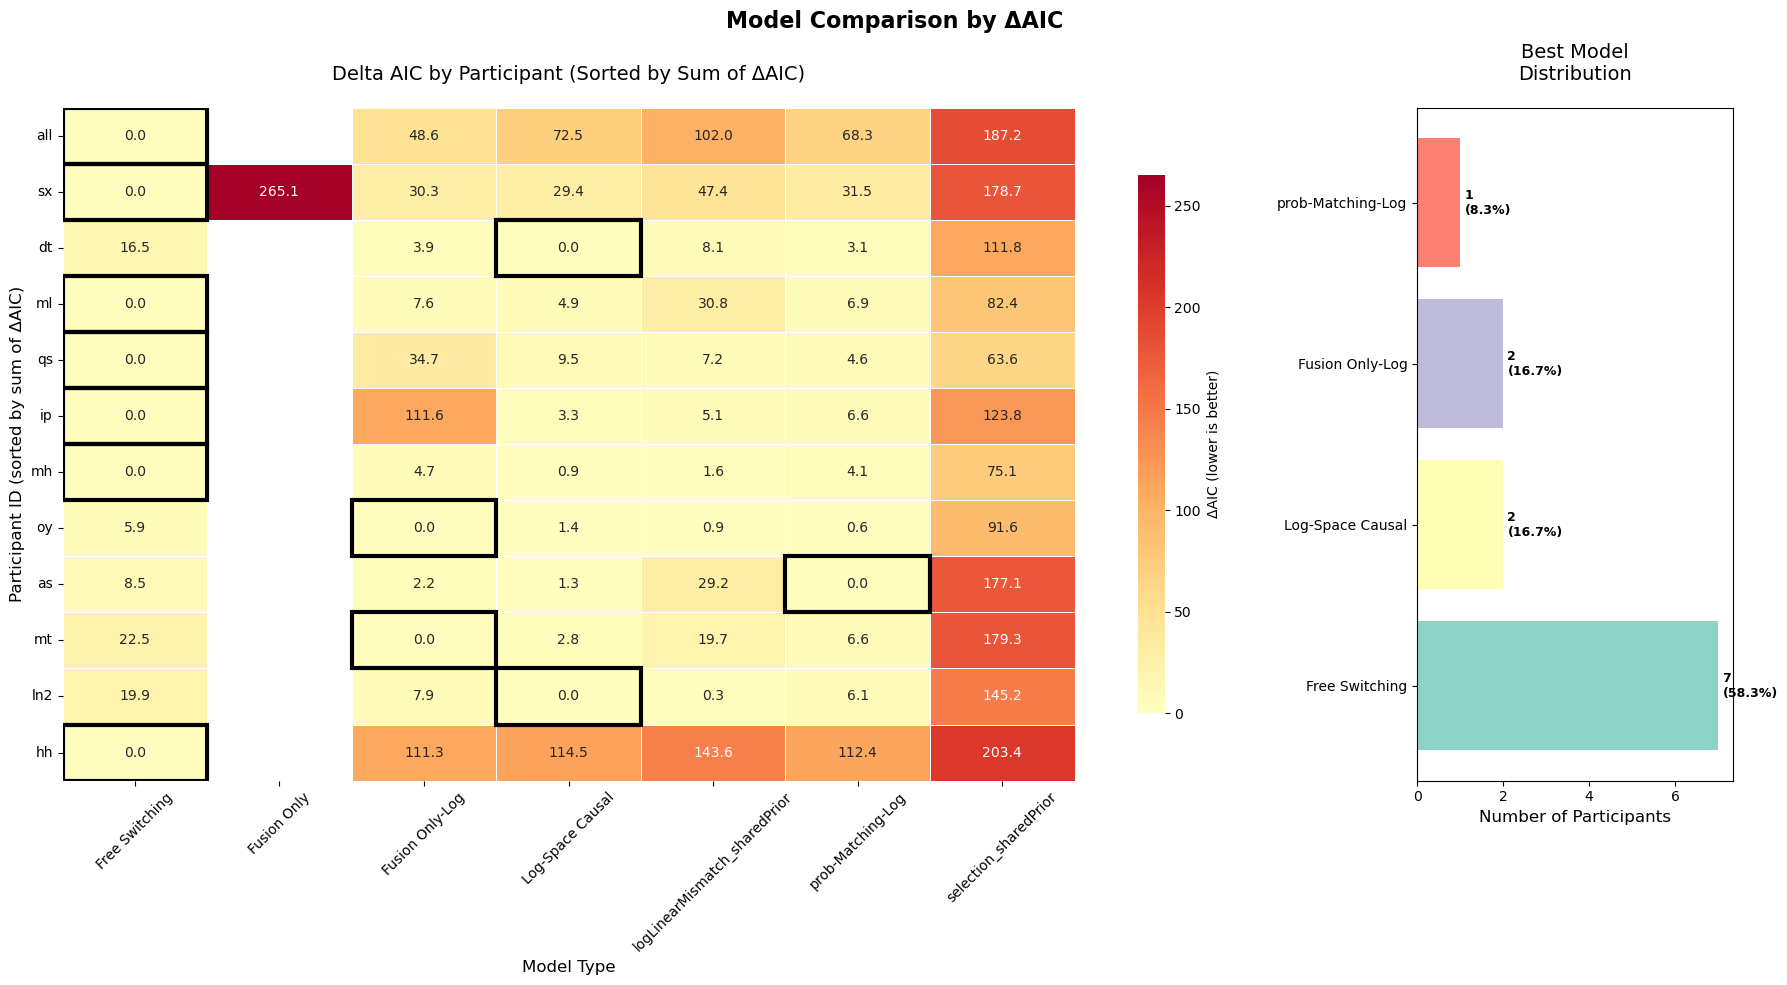

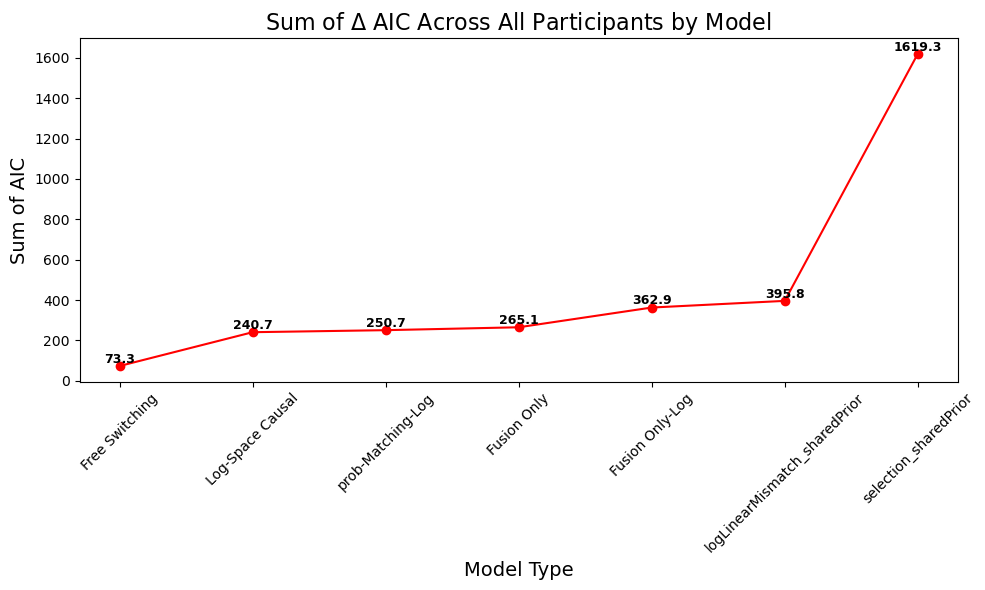

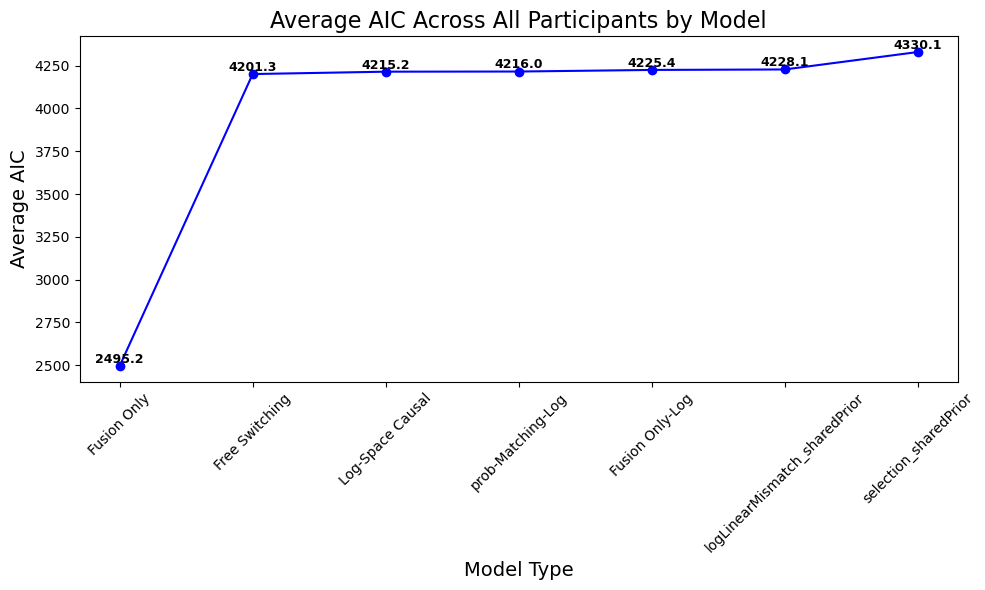

1    all          152060.9   Free Switching     25263.7    Poor fit       
2    sx           16193.4    Free Switching     2230.1     Poor fit       
3    dt           15608.2    Log-Space Causal   2577.5     Poor fit       
4    ml           15165.8    Free Switching     2505.5     Poor fit       
5    qs           15157.7    Free Switching     2506.4     Poor fit       
6    ip           14772.1    Free Switching     2420.3     Poor fit       
7    mh           14653.8    Free Switching     2427.9     Poor fit       
8    oy           14114.5    Fusion Only-Log    2335.7     Poor fit       
9    as           14041.4    prob-Matching-Log  2303.9     Poor fit       
10   mt           13621.3    Fusion Only-Log    2231.7     Poor fit       
11   ln2          13529.2    Log-Space Causal   2225.0     Poor fit       
12   hh           8570.2     Free Switching     1314.2     Poor fit       


In [ ]:
# Calculate delta_AIC for each model relative to the best model per participant
df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())

# Sort participants by sum of delta_AIC across all models (lower sum = better overall performance)
participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
sorted_participants = participant_delta_sums.index.tolist()
print("Participants sorted by sum of delta_AIC across all models (lowest to highest):")
print(f"Delta_AIC sums: {participant_delta_sums.to_dict()}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create enhanced table-style visualization
def plot_sorted_model_comparison_table(df_results,compBase='AIC', notFusion=1, sumCompBase=0):
    
    if notFusion:
        removeModels= ["Fusion Only", "Fusion Only-Log"]
        df_results = df_results[~df_results['modelType'].isin(removeModels)]
    """Create a comprehensive table plot with participants sorted by sum of delta_AIC"""
    
    # Calculate delta_AIC for each model relative to the best model
    df_results['delta_AIC'] = df_results.groupby('participantID')[compBase].transform(lambda x: x - x.min())
    
    # Sort participants by sum of delta_AIC across all models
    participant_delta_sums = df_results.groupby('participantID')['logLikelihood'].sum().sort_values()
    sorted_participants = participant_delta_sums.index.tolist()
    
    # Create the pivot table with sorted participants
    df_delta_aic = df_results.pivot(index='participantID', columns='modelType', values='delta_AIC')
    df_delta_aic = df_delta_aic.reindex(sorted_participants)
    
    # Find best model for each participant
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data[compBase].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle(f'Model Comparison by Δ{compBase}', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta_AIC values
    sns.heatmap(df_delta_aic, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': f'Δ{compBase} (lower is better)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title(f'Delta {compBase} by Participant (Sorted by Sum of Δ{compBase})', fontsize=14, pad=20)
    ax1.set_ylabel(f'Participant ID (sorted by sum of Δ{compBase})', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_aic.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a star or border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Model\nDistribution', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # we want to plot a line chart of sum of AIC per model
    model_sums = df_results.groupby('modelType')["delta_AIC"].sum().sort_values()
    plt.figure(figsize=(10, 6))
    plt.plot(model_sums.index, model_sums.values, marker='o', linestyle='-', color='r')
    plt.title(f'Sum of $\Delta$ AIC Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel(f'Sum of {compBase}', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    # Add value labels on points
    for i, value in enumerate(model_sums.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Another plot to show average AIC per model as a line plot
    model_means = df_results.groupby('modelType')[compBase].mean().sort_values()
    plt.figure(figsize=(10, 6))
    plt.plot(model_means.index, model_means.values, marker='o', linestyle='-', color='b')
    # Add value labels on points
    for i, value in enumerate(model_means.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.title(f'Average {compBase} Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel(f'Average {compBase}', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data[compBase].sum()
        min_delta_aic = participant_data[compBase].min()
        best_model = participant_data.loc[participant_data[compBase].idxmin(), 'modelType']
        
        if sum_delta_aic <= 5:
            performance = "Excellent fit"
        elif sum_delta_aic <= 15:
            performance = "Good fit"
        elif sum_delta_aic <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_aic:<10.1f} {best_model:<18} {min_delta_aic:<10.1f} {performance:<15}")
    
    return df_delta_aic, best_models, participant_delta_sums

# Create the enhanced visualization
delta_aic_table, participant_best_models, delta_sums = plot_sorted_model_comparison_table(df_results,compBase='AIC', notFusion=1,sumCompBase=1)

In [9]:
# Simple Model Comparison Table with Log Likelihoods
def create_simple_comparison_table(df_results):
    """Create a simple comparison table focused on log likelihoods"""
    
    # Pivot to show log likelihoods for each participant-model combination
    log_likelihood_table = df_results.pivot(
        index='participantID', 
        columns='modelType', 
        values='logLikelihood'
    )
    
    # Sort participants by ID for consistent ordering
    log_likelihood_table = log_likelihood_table.sort_index()
    
    return log_likelihood_table

# Create the simple comparison table
simple_table = create_simple_comparison_table(df_results)

print("Model Comparison Table - Log Likelihoods")
print("=" * 80)
print("Higher values indicate better fit")
print("=" * 80)
print()

# Display with better formatting
pd.set_option('display.float_format', '{:.2f}'.format)
display(simple_table)

# Reset display options
pd.reset_option('display.float_format')

Model Comparison Table - Log Likelihoods
Higher values indicate better fit



modelType,Free Switching,Fusion Only,Fusion Only-Log,Log-Space Causal,logLinearMismatch_sharedPrior,prob-Matching-Log,selection_sharedPrior
participantID,,,,,,,
all,-12623.85,NaN,-12650.18,-12661.08,-12675.85,-12659.02,-12718.45
as,-1151.16,NaN,-1150.03,-1148.60,-1162.52,-1147.93,-1236.46
dt,-1292.00,NaN,-1287.67,-1284.73,-1288.78,-1286.29,-1340.63
hh,-652.08,NaN,-709.72,-710.35,-724.88,-709.28,-754.79
ip,-1205.14,NaN,-1262.96,-1207.80,-1208.67,-1209.43,-1268.04
ln2,-1117.45,NaN,-1113.44,-1108.49,-1108.62,-1111.52,-1181.11
mh,-1208.95,NaN,-1213.30,-1210.42,-1210.74,-1211.99,-1247.48
ml,-1247.76,NaN,-1253.56,-1251.22,-1264.15,-1252.22,-1289.96
mt,-1122.11,NaN,-1112.86,-1113.29,-1121.73,-1115.14,-1201.52


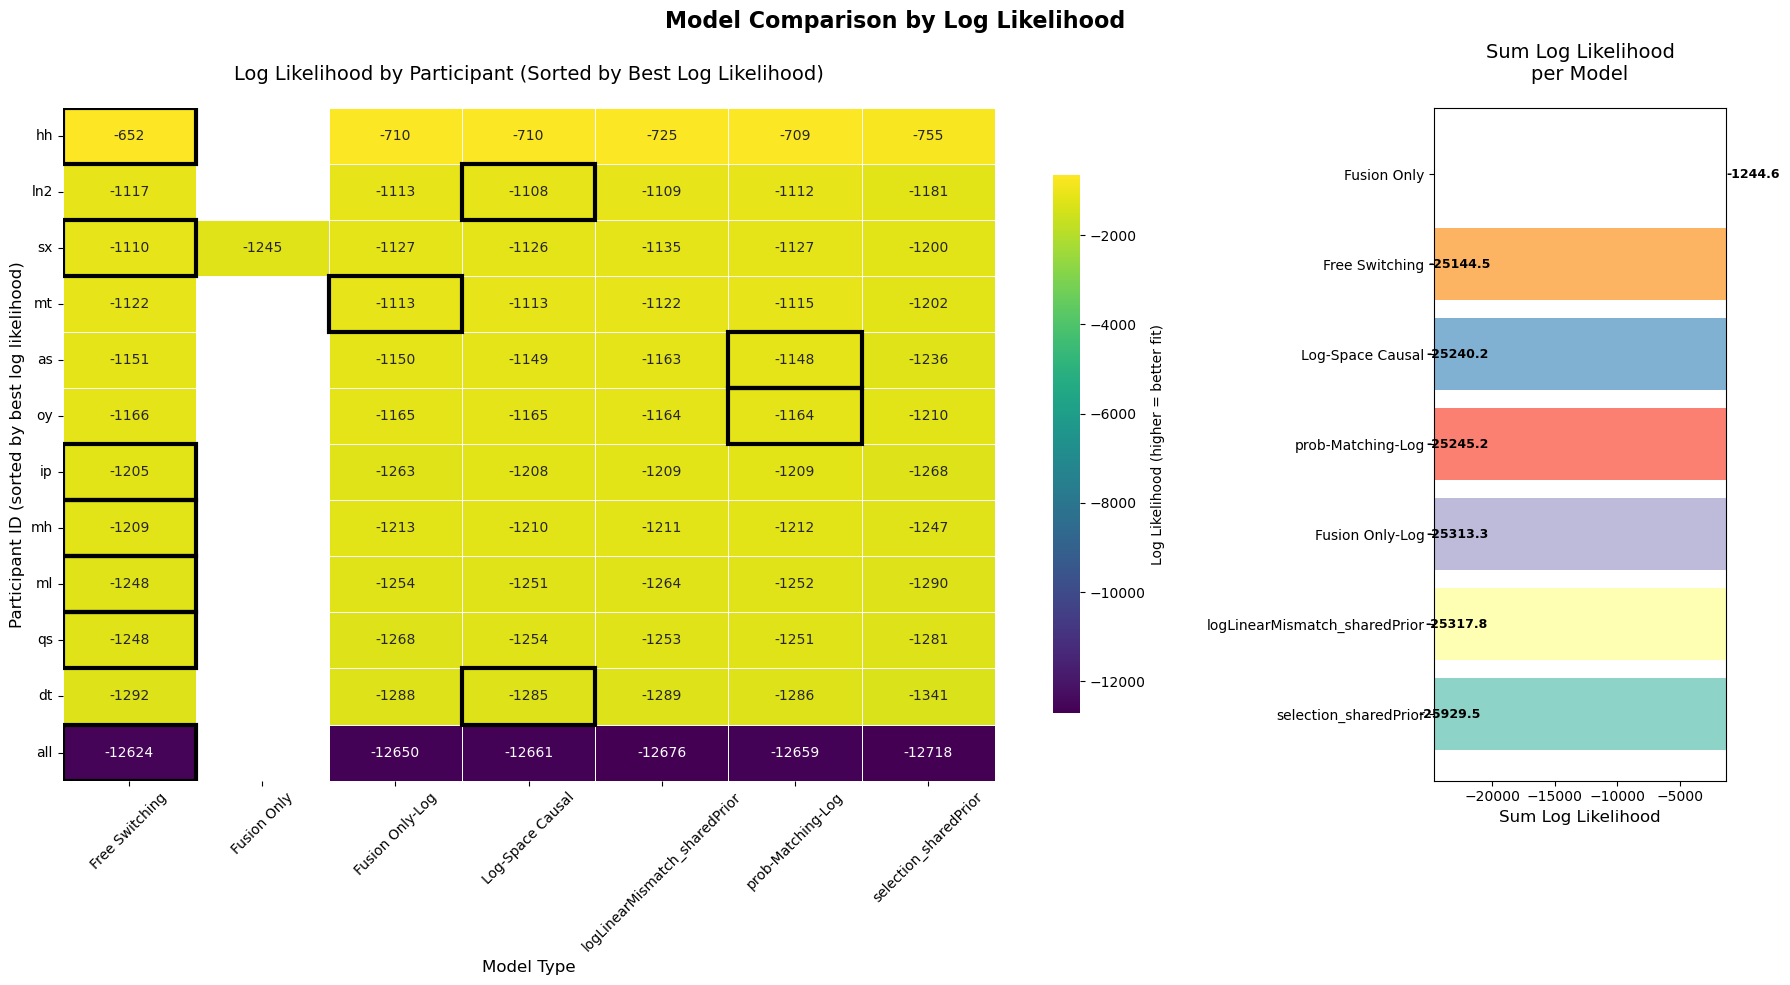


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    hh           -652       Free Switching     685.3      Good fit       
2    ln2          -1108      Log-Space Causal   179.4      Moderate fit   
3    sx           -1110      Free Switching     582.5      Moderate fit   
4    mt           -1113      Fusion Only-Log    230.9      Moderate fit   
5    as           -1148      prob-Matching-Log  218.2      Moderate fit   
6    oy           -1164      prob-Matching-Log  100.5      Moderate fit   
7    ip           -1205      Free Switching     250.4      Poor fit       
8    mh           -1209      Free Switching     86.4       Poor fit       
9    ml           -1248      Free Switching     132.6      Poor fit       
10   qs           -1248      Free Switching     119.5      Poor fit       
11   dt           -1285  

In [10]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns


def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Sum Log Likelihood per model - sum across rows (participants) for each model column
    sum_ll = df_log_likelihood.sum(axis=0).sort_values()  # sum across participants for each model
    colors = plt.cm.Set3(range(len(sum_ll)))
    
    bars = ax2.barh(range(len(sum_ll)), sum_ll.values, color=colors)
    ax2.set_yticks(range(len(sum_ll)))
    ax2.set_yticklabels(sum_ll.index, fontsize=10)
    ax2.set_xlabel('Sum Log Likelihood', fontsize=12)
    ax2.set_title('Sum Log Likelihood\nper Model', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sum_ll.values)):
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}',
                 ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Set limits for the heatmap axes
    ax2.set_xlim(min(sum_ll.values)*0.95, max(sum_ll.values)*1.05)

    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models
# ...existing code...

    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)

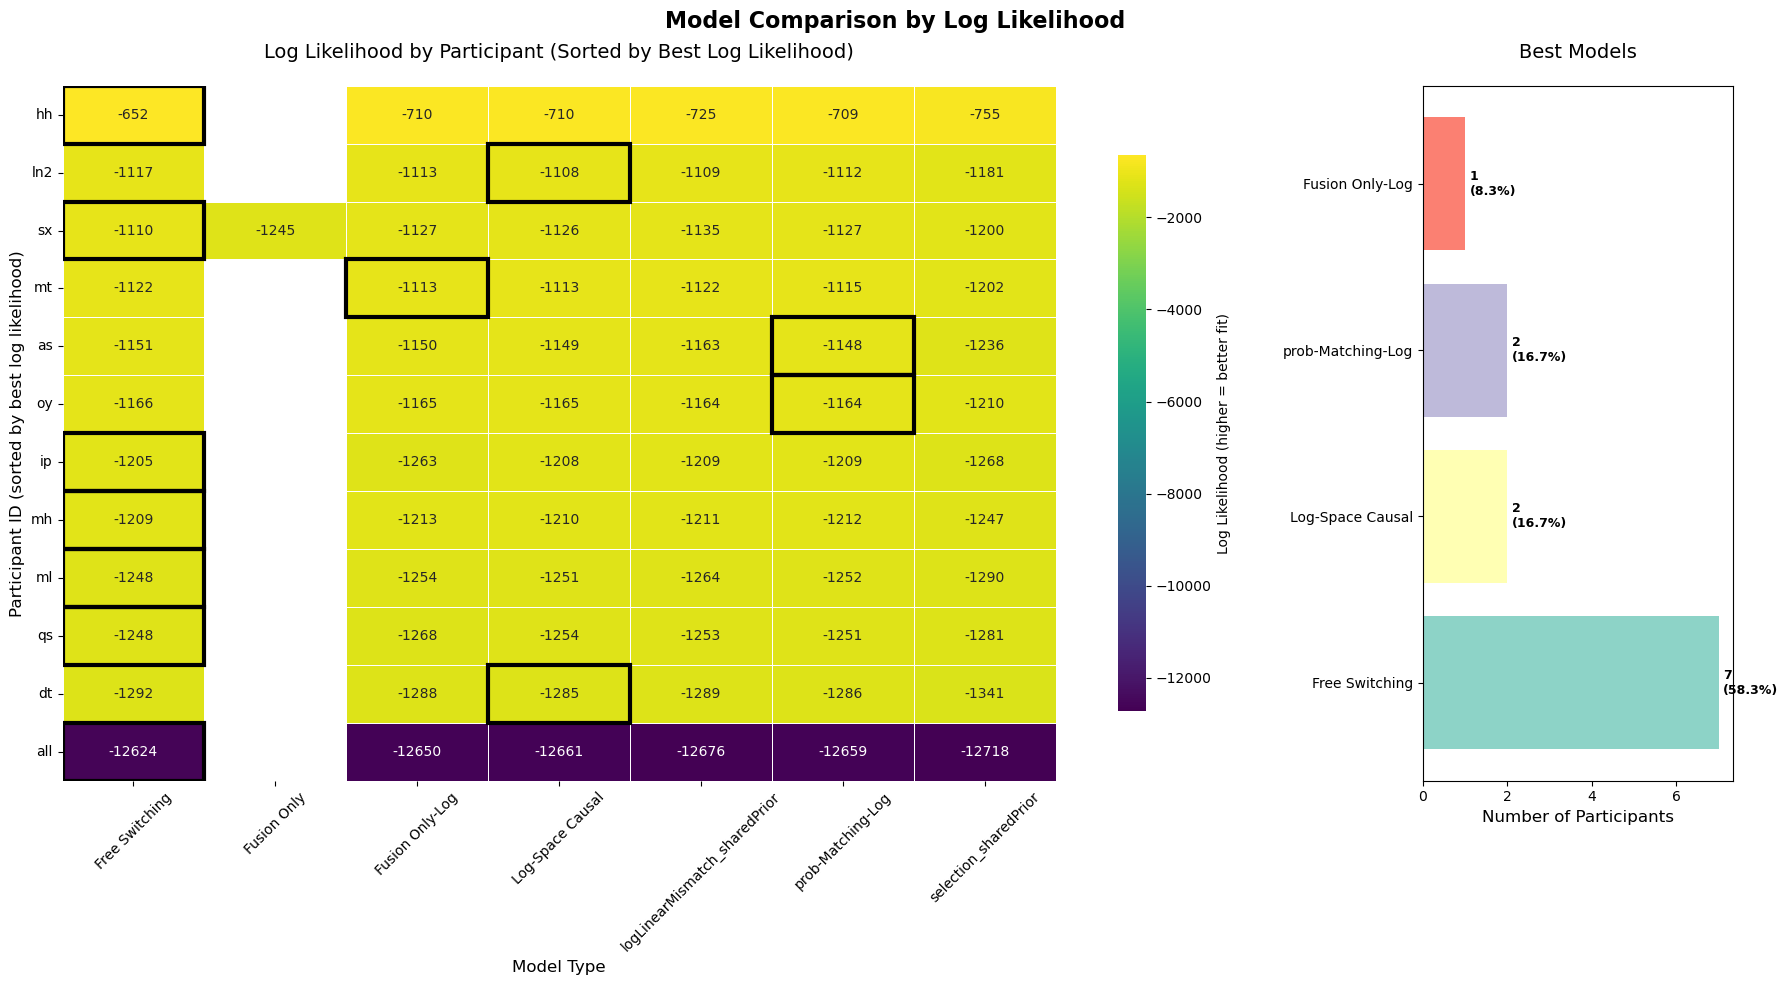


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    hh           -652       Free Switching     685.3      Good fit       
2    ln2          -1108      Log-Space Causal   179.4      Moderate fit   
3    sx           -1110      Free Switching     582.5      Moderate fit   
4    mt           -1113      Fusion Only-Log    230.9      Moderate fit   
5    as           -1148      prob-Matching-Log  218.2      Moderate fit   
6    oy           -1164      prob-Matching-Log  100.5      Moderate fit   
7    ip           -1205      Free Switching     250.4      Poor fit       
8    mh           -1209      Free Switching     86.4       Poor fit       
9    ml           -1248      Free Switching     132.6      Poor fit       
10   qs           -1248      Free Switching     119.5      Poor fit       
11   dt           -1285  

In [11]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Models', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)

In [12]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions,nParameters,AIC_recalculated,delta_AIC,delta_LL
0,sx,Free Switching,"[0.0010002813415979916, 0.24673807644906276, 0...",2230.135895,2251.667271,-1110.067947,548,8,2236.135895,0.000000,0.000000
1,sx,Log-Space Causal,"[0.001000000004644952, 0.24673807644906276, 0....",2259.531611,2276.756712,-1125.765806,548,7,2265.531611,29.395717,15.697858
2,sx,logLinearMismatch_sharedPrior,"[0.004089603181311568, 0.24673807644906276, 0....",2277.569024,2294.794125,-1134.784512,548,7,2283.569024,47.433129,24.716564
3,sx,Fusion Only,"[0.002594144436608964, 0.6241188349324437, 0.6...",2495.197092,2508.115918,-1244.598546,548,6,2501.197092,265.061197,134.530599
4,sx,Fusion Only-Log,"[0.0026196144590546577, 0.24673807644906276, 0...",2260.481407,2273.400233,-1127.240703,548,6,2266.481407,30.345512,17.172756
...,...,...,...,...,...,...,...,...,...,...,...
68,ip,selection_sharedPrior,"[0.0010000011891126426, 0.3891260317299929, 0....",2544.082234,2560.884270,-1268.041117,493,7,2550.082234,123.804305,62.902152
69,ip,prob-Matching-Log,"[0.03162515383084427, 0.3891260317299929, 0.42...",2426.864939,2443.666976,-1209.432470,493,7,2432.864939,6.587010,4.293505
70,ip,Log-Space Causal,"[0.041094481605663896, 0.3891260317299929, 0.4...",2423.594654,2440.396691,-1207.797327,493,7,2429.594654,3.316726,2.658363
71,ip,logLinearMismatch_sharedPrior,"[0.036525871814043306, 0.3891260317299929, 0.4...",2425.347186,2442.149223,-1208.673593,493,7,2431.347186,5.069257,3.534629


Participant all: lambda_1=0.1148295617881552, sigma_a=0.26510078233769274, sigma_v=0.5252749505013505, p_c=0.9944184451434158,sigma_a2=0.568894575886471, lambda_2=0.09512338326531265, lambda_3=0.17045617522356135
Participant as: lambda_1=0.0010000000002902965, sigma_a=0.23842696610960668, sigma_v=1.1840946689607288, p_c=0.9999886520559813,sigma_a2=3.5, lambda_2=0.0462796170599202, lambda_3=0.0010033697085393145
Participant dt: lambda_1=0.078082350471249, sigma_a=0.33367513379194225, sigma_v=0.7271954744365885, p_c=0.8302024743817029,sigma_a2=2.222825957592445, lambda_2=0.0010000844447533852, lambda_3=0.057128545855185925
Participant hh: lambda_1=0.23534187622070313, sigma_a=0.01, sigma_v=0.5054529557029364, p_c=0.9999877929687501,sigma_a2=2.1308123367226153, lambda_2=0.3419643005371094, lambda_3=0.2364377624511719
Participant ip: lambda_1=0.041094481605663896, sigma_a=0.3891260317299929, sigma_v=0.429405374849717, p_c=0.058724678307771616,sigma_a2=0.521550904883722, lambda_2=0.06153045

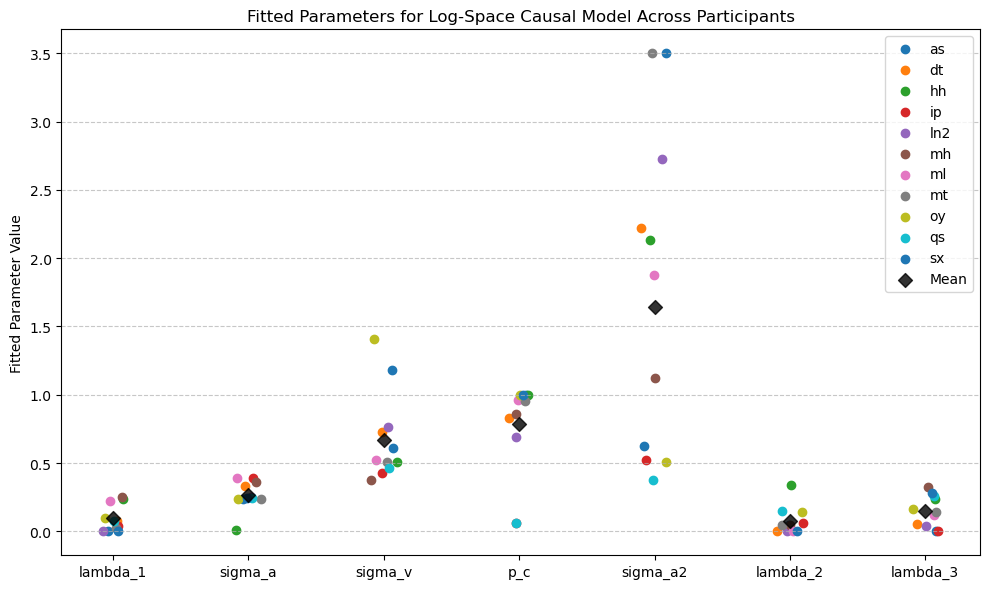

In [13]:
import numpy as np
import matplotlib.pyplot as plt
def plot_parameter_fits(df_results,model_name='Log-Space Causal'):
    # example fittedParams for Log-Space Causal model
    # fittedParams: [lambda_1, sigma_a, sigma_v, sigma_a2,lambda_2, lambda_3]
    participantIDs= sorted(df_results['participantID'].unique())
    modelTypes= sorted(df_results['modelType'].unique())
    paramFits= {}
    for pid in participantIDs:
        participant_data = df_results[df_results['participantID'] == pid]
        pid_lognorm_fit = participant_data[participant_data['modelType'] == model_name]
        lambda_1_Fit = pid_lognorm_fit['fittedParams'].values[0][0]
        sigma_a_Fit = pid_lognorm_fit['fittedParams'].values[0][1]
        sigma_v_Fit = pid_lognorm_fit['fittedParams'].values[0][2]
        p_c= pid_lognorm_fit['fittedParams'].values[0][3]
        sigma_a2_Fit = pid_lognorm_fit['fittedParams'].values[0][4]
        lambda_2_Fit = pid_lognorm_fit['fittedParams'].values[0][5]
        lambda_3_Fit = pid_lognorm_fit['fittedParams'].values[0][6]    
        print(f"Participant {pid}: lambda_1={lambda_1_Fit}, sigma_a={sigma_a_Fit}, sigma_v={sigma_v_Fit}, p_c={p_c},sigma_a2={sigma_a2_Fit}, lambda_2={lambda_2_Fit}, lambda_3={lambda_3_Fit}")
        paramFits[pid]= {
            'lambda_1': lambda_1_Fit,
            'sigma_a': sigma_a_Fit,
            'sigma_v': sigma_v_Fit,
            'p_c': p_c,
            'sigma_a2': sigma_a2_Fit,
            'lambda_2': lambda_2_Fit,
            'lambda_3': lambda_3_Fit
        }

    




    # plot the parameter fits scatter plot with jittered x-axis values for each parameter
    plt.figure(figsize=(10, 6))
    parameters = ['lambda_1', 'sigma_a', 'sigma_v', 'p_c', 'sigma_a2', 'lambda_2', 'lambda_3']
    x_positions = np.arange(len(parameters))
    for pid in participantIDs:
        if pid=='all':
            # color='red'
            # fits = paramFits[pid]
            # y_values = [fits[param] for param in parameters]
            # plt.scatter(x_positions, y_values, label=pid, color=color, s=100, edgecolor='red')
            continue
        fits = paramFits[pid]
        y_values = [fits[param] for param in parameters]
        # Add jitter to x positions
        jitter = np.random.uniform(-0.1, 0.1, size=len(parameters))
        plt.scatter(x_positions + jitter, y_values, label=pid)

    # Add mean markers for each parameter
    for i, param in enumerate(parameters):
        mean_value = np.mean([paramFits[pid][param] for pid in participantIDs])
        plt.scatter(i, mean_value, color='black', marker='D', s=50, alpha=0.8,label='Mean' if i == 0 else "")

    plt.xticks(x_positions, parameters)
    plt.ylabel('Fitted Parameter Value')
    plt.title('Fitted Parameters for Log-Space Causal Model Across Participants')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_parameter_fits(df_results,model_name='Log-Space Causal')

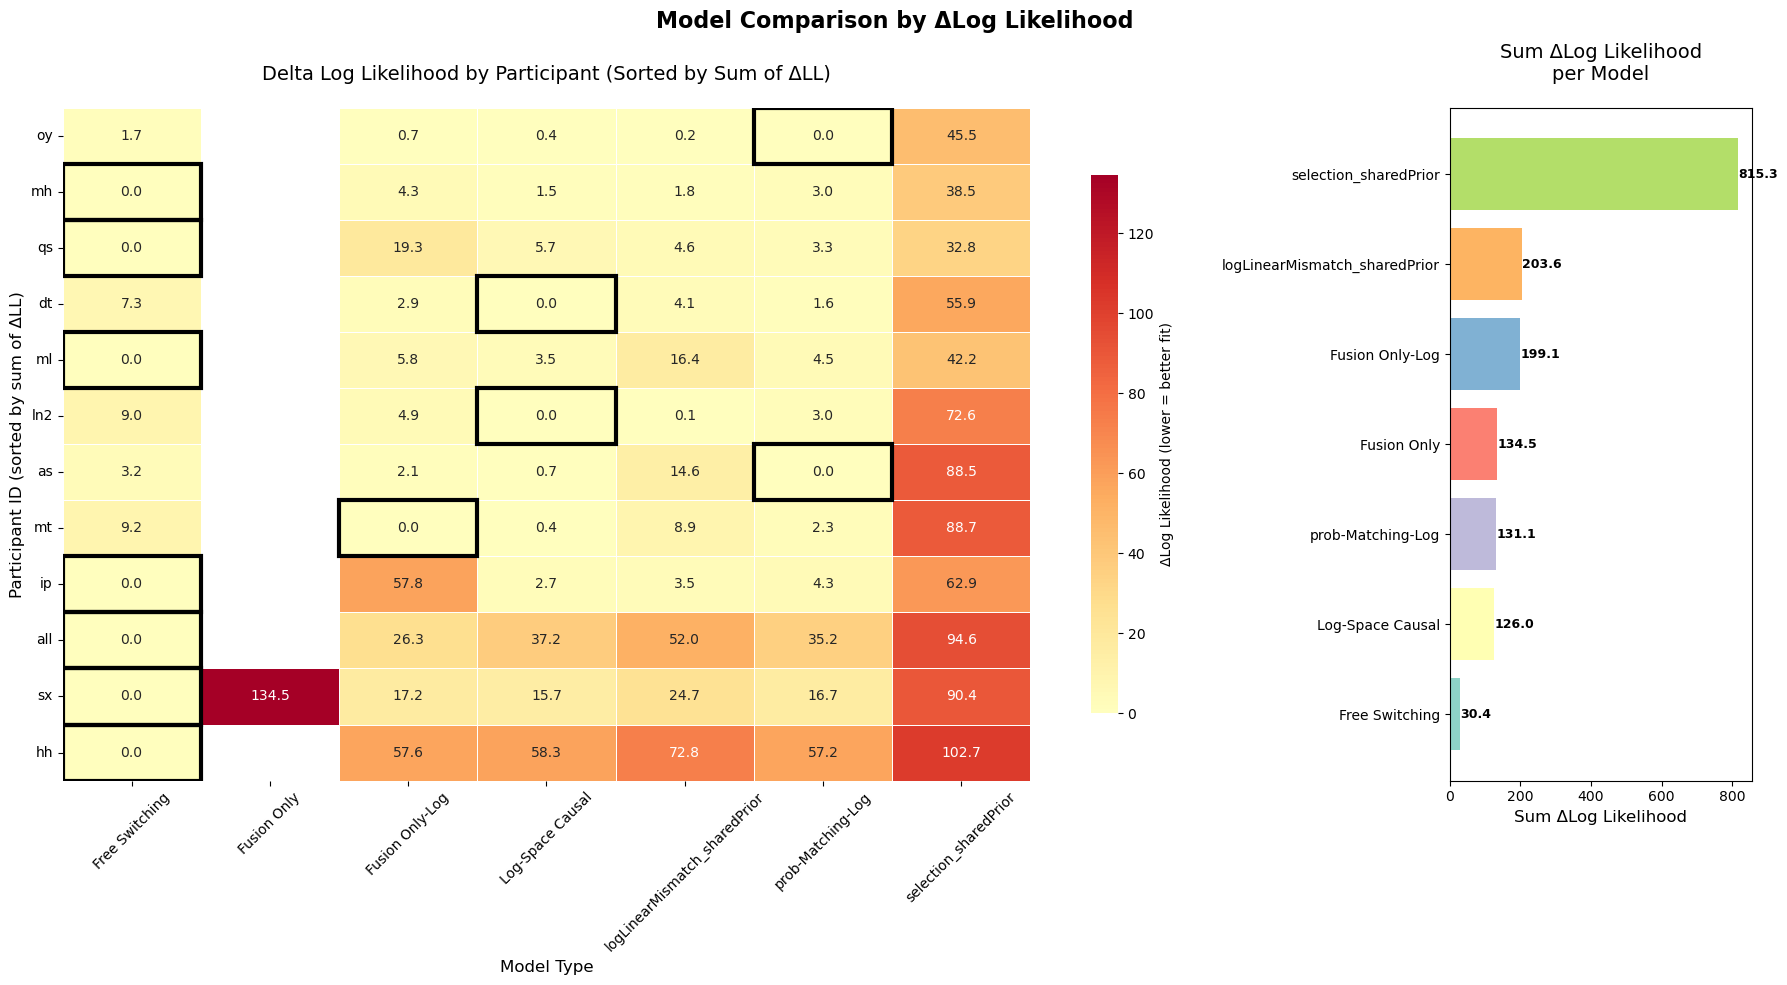

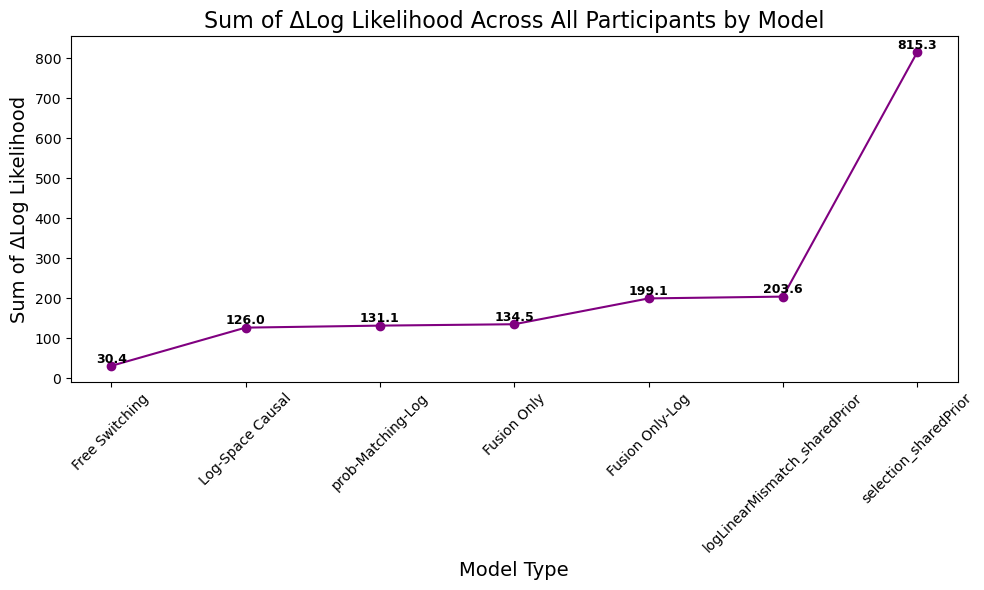


PARTICIPANT RANKING TABLE (sorted by sum of ΔLog Likelihood)
Rank Participant  Sum ΔLL    Best Model         Min ΔLL    Performance    
------------------------------------------------------------------------------------------
1    oy           48.5       prob-Matching-Log  0.0        Poor fit       
2    mh           49.2       Free Switching     0.0        Poor fit       
3    qs           65.8       Free Switching     0.0        Poor fit       
4    dt           71.7       Log-Space Causal   0.0        Poor fit       
5    ml           72.3       Free Switching     0.0        Poor fit       
6    ln2          89.7       Log-Space Causal   0.0        Poor fit       
7    as           109.1      prob-Matching-Log  0.0        Poor fit       
8    mt           109.5      Fusion Only-Log    0.0        Poor fit       
9    ip           131.2      Free Switching     0.0        Poor fit       
10   all          245.3      Free Switching     0.0        Poor fit       
11   sx           299.

In [14]:
# Plot Delta Log Likelihood Comparison Table
import matplotlib.pyplot as plt
import seaborn as sns

def plot_delta_log_likelihood_comparison_table(df_results):
    """Create a comprehensive delta log likelihood comparison plot"""
    
    # Sort participants by sum of delta_LL (lower is better since it's distance from best)
    participant_delta_ll_sums = df_results.groupby('participantID')['delta_LL'].sum().sort_values()
    sorted_participants = participant_delta_ll_sums.index.tolist()
    
    # Create the pivot table with sorted participants for delta log likelihoods
    df_delta_ll = df_results.pivot(index='participantID', columns='modelType', values='delta_LL')
    df_delta_ll = df_delta_ll.reindex(sorted_participants)
    
    # Find best model for each participant (lowest delta_LL = highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['delta_LL'].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by ΔLog Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta log likelihood values
    sns.heatmap(df_delta_ll, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': 'ΔLog Likelihood (lower = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Delta Log Likelihood by Participant (Sorted by Sum of ΔLL)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by sum of ΔLL)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (black borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_ll.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Sum Delta LL per model
    sum_delta_ll = df_delta_ll.sum(axis=0).sort_values()
    colors = plt.cm.Set3(range(len(sum_delta_ll)))
    
    bars = ax2.barh(range(len(sum_delta_ll)), sum_delta_ll.values, color=colors)
    ax2.set_yticks(range(len(sum_delta_ll)))
    ax2.set_yticklabels(sum_delta_ll.index, fontsize=10)
    ax2.set_xlabel('Sum ΔLog Likelihood', fontsize=12)
    ax2.set_title('Sum ΔLog Likelihood\nper Model', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sum_delta_ll.values)):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}',
                 ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Line plot showing sum of delta LL per model
    plt.figure(figsize=(10, 6))
    plt.plot(sum_delta_ll.index, sum_delta_ll.values, marker='o', linestyle='-', color='purple')
    plt.title('Sum of ΔLog Likelihood Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel('Sum of ΔLog Likelihood', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    # Add value labels on points
    for i, value in enumerate(sum_delta_ll.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by sum of ΔLog Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Sum ΔLL':<10} {'Best Model':<18} {'Min ΔLL':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_ll = participant_data['delta_LL'].sum()
        min_delta_ll = participant_data['delta_LL'].min()
        best_model = participant_data.loc[participant_data['delta_LL'].idxmin(), 'modelType']
        
        if sum_delta_ll <= 5:
            performance = "Excellent fit"
        elif sum_delta_ll <= 15:
            performance = "Good fit"
        elif sum_delta_ll <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_ll:<10.1f} {best_model:<18} {min_delta_ll:<10.1f} {performance:<15}")
    
    return df_delta_ll, best_models, participant_delta_ll_sums

# Create the delta log likelihood visualization
delta_ll_table, delta_ll_best_models, delta_ll_sums = plot_delta_log_likelihood_comparison_table(df_results)